# Wheat vs Non_Wheat Classifier

## Basic Charateristic Check

In [ ]:
from glob import glob
import geopandas as gp
import numpy as np
import pandas as pd
import pickle
from copy import deepcopy
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
import torch
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler as lr_sc
import random

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df1 = pd.read_csv(r'data_files/Copy of NDVI Wheat MP 5 periods 10 Bands - Sheet1.csv')
df2 = pd.read_csv(r'data_files/Copy of NDVI Wheat MP 5 periods 10 Bands - Sheet2.csv')

In [ ]:
wheat = pd.concat([df1, df2], axis=1)

In [ ]:
wheat.head(2)

,0,1,2,3,4,5,6,7,8,9,Label,latitude,longitude,Dist
0,117,154,185,186,191,191,185,177,131,120,0,23.22102420000,75.54814340000,UJJAIN
1,118,153,172,182,189,181,173,157,124,118,0,22.74924340000,76.28596060000,DEWAS


In [ ]:
wheat.rename({'0':'oct_2f', '1':'nov_1f', '2':'nov_2f', '3':'dec_1f', '4':'dec_2f', '5':'jan_1f', '6':'jan_2f', '7':'feb_1f', '8':'feb_2f', '9':'mar_1f', 'Label':'label', 'Dist':'district'}, axis=1, inplace=True)

In [ ]:
wheat.drop(['latitude', 'longitude'], axis=1, inplace=True)

In [ ]:
wheat.head(2)

,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f,label,district
0,117,154,185,186,191,191,185,177,131,120,0,UJJAIN
1,118,153,172,182,189,181,173,157,124,118,0,DEWAS


In [ ]:
xlsx = pd.ExcelFile('data_files/MP_crop_profiles.xlsx')
gram = pd.read_excel(xlsx, 'Gram')
mustard = pd.read_excel(xlsx, 'Mustard')
mustard1 = pd.read_excel(r'data_files/Mustard_GT_profiles_MP_30may23.xlsx')
pulses = pd.read_excel(xlsx, 'pulses')

In [ ]:
mustard1.head(3)

,lat,long,Crop_Nam_1,STATE_NAME,DISTRICT,Oct_2FN,Nov_1FN,Nov_2FN,Dec_1FN,Dec_2FN,Jan_1FN,Jan_2FN,Feb_1Fn,Feb_2Fn,Mar_1Fn
0,24.031002,75.761473,2 Mustard,Madhya Pradesh,MANDSAUR,131,130,178,185,183,183,184,181,150,130
1,24.326160,75.020576,2 Mustard,Madhya Pradesh,MANDSAUR,118,130,174,190,189,187,182,160,127,125
2,25.300808,78.009660,2 Mustard,Madhya Pradesh,SHIVPURI,125,130,180,189,187,183,184,179,155,131


In [ ]:
mustard1.drop(['lat', 'long', 'STATE_NAME'], axis=1, inplace=True)
mustard1.rename({'Crop_Nam_1':'label'}, axis=1, inplace=True)
mustard1.label = mustard1.label.apply(lambda row : row[2:])
mustard1.columns = ['label', 'district', 'oct_2f', 'nov_1f', 'nov_2f', 'dec_1f', 'dec_2f', 'jan_1f', 'jan_2f', 'feb_1f', 'feb_2f', 'mar_1f']

In [ ]:
pulses.head(2)

,label,district,Oct_2F,Nov_1F,Nov_2F,Dec_1F,Dec_2F,Jan_1F,Jan_2F,Feb_1F,Feb_2F,Mar_1F
0,Pulses,ALIRAJPUR,158,131,132,134,149,157,161,159,141,127
1,Pulses,ALIRAJPUR,156,134,134,128,143,160,158,161,157,140


In [ ]:
for crop_data in [mustard, gram, pulses]:
    crop_data.columns = map(str.lower, crop_data.columns)

In [ ]:
df = pd.concat([wheat, mustard, gram, pulses, mustard1], ignore_index=True)

In [ ]:
df.shape[0]

19210

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19210 entries, 0 to 19209
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   oct_2f    19210 non-null  object
 1   nov_1f    19210 non-null  object
 2   nov_2f    19210 non-null  object
 3   dec_1f    19210 non-null  object
 4   dec_2f    19210 non-null  object
 5   jan_1f    19210 non-null  object
 6   jan_2f    19210 non-null  object
 7   feb_1f    19210 non-null  object
 8   feb_2f    19210 non-null  object
 9   mar_1f    19210 non-null  object
 10  label     19210 non-null  object
 11  district  19210 non-null  object
dtypes: object(12)
memory usage: 1.8+ MB


In [ ]:
def int_check(val):
    try:
        val = int(val)
    except:
        pass
    return val

In [ ]:
df = df.drop(10906)

In [ ]:
for i in df.columns[:10]:
    df[i] = df[i].astype(int)

In [ ]:
df.district = df.district.astype(str)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19209 entries, 0 to 19209
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   oct_2f    19209 non-null  int32 
 1   nov_1f    19209 non-null  int32 
 2   nov_2f    19209 non-null  int32 
 3   dec_1f    19209 non-null  int32 
 4   dec_2f    19209 non-null  int32 
 5   jan_1f    19209 non-null  int32 
 6   jan_2f    19209 non-null  int32 
 7   feb_1f    19209 non-null  int32 
 8   feb_2f    19209 non-null  int32 
 9   mar_1f    19209 non-null  int32 
 10  label     19209 non-null  object
 11  district  19209 non-null  object
dtypes: int32(10), object(2)
memory usage: 1.2+ MB


In [ ]:
df.describe()

,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f
count,19209.000000,19209.000000,19209.000000,19209.000000,19209.000000,19209.000000,19209.000000,19209.000000,19209.000000,19209.000000
mean,144.435681,129.791504,130.561351,145.213650,169.505076,180.495653,183.448800,185.414858,179.702327,161.724348
std,17.304535,13.316600,14.430981,20.828144,16.231467,13.577124,6.503395,6.665503,13.541293,22.040497
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,130.000000,120.000000,122.000000,128.000000,158.000000,176.000000,180.000000,183.000000,176.000000,144.000000
50%,142.000000,126.000000,126.000000,138.000000,173.000000,183.000000,184.000000,187.000000,184.000000,169.000000
75%,157.000000,136.000000,133.000000,162.000000,183.000000,187.000000,188.000000,189.000000,188.000000,180.000000
max,200.000000,195.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000


In [ ]:
# No null values
df.isna().sum().sum()

0

In [ ]:
df.label.value_counts()

2          7175
3          5558
1          3637
Mustard    2048
Gram        351
4           245
Pulses      101
0            94
Name: label, dtype: int64

In [ ]:
df['fn_label'] = df.label.apply(lambda row : 5 if (type(row) != int) else row)

In [ ]:
df['label'] = df.label.apply(lambda row : 1 if (type(row) == int) else 0)

In [ ]:
df.label.value_counts(), df.fn_label.value_counts()

(1    16709
 0     2500
 Name: label, dtype: int64,
 2    7175
 3    5558
 1    3637
 5    2500
 4     245
 0      94
 Name: fn_label, dtype: int64)

In [ ]:
df.drop('district', axis=1, inplace=True)

## RNN Classifier

### Undesampling

In [ ]:
df.label.value_counts(normalize=True), df.label.value_counts()

(1    0.869853
 0    0.130147
 Name: label, dtype: float64,
 1    16709
 0     2500
 Name: label, dtype: int64)

In [ ]:
wheat = df[df.label==1]

target_wheat = int(df.label.value_counts()[0] * 0.7/0.3)

split_per = target_wheat/df.label.value_counts()[1]

_, wheat = train_test_split(wheat, test_size=split_per, 
                            stratify=wheat.fn_label, random_state=0)

df = pd.concat([df[df.label==0], wheat])

df.label.value_counts(normalize=True), df.label.value_counts()

(1    0.699988
 0    0.300012
 Name: label, dtype: float64,
 1    5833
 0    2500
 Name: label, dtype: int64)

### Train-Val Split

In [ ]:
X = df.drop('label', axis=1)
y = df['label']


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, 
                                                  stratify=X.fn_label, random_state=0)

X_train.drop('fn_label', axis=1, inplace=True)
X_val.drop('fn_label', axis=1, inplace=True)

### Scaling

In [ ]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

y_train = pd.get_dummies(y_train)
y_val = pd.get_dummies(y_val)

In [ ]:
pickle.dump(scaler, open(r'models/RNN_Binary_StandardScaler_1.1', 'wb'))

### Tensor conversion and Torch Data loading

In [ ]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = np.zeros((len(y), 1))
        self.y = y
        self.shuffle = shuffle

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            if len(test_idx) > batch_size:
                test_idx = test_idx[:-(len(test_idx) - batch_size)]
            yield test_idx

    def __len__(self):
        return len(self.y)

In [ ]:
batch_size = 8

train_features = torch.Tensor(X_train.values)
train_targets = torch.Tensor(y_train.values)
val_features = torch.Tensor(X_val.values)
val_targets = torch.Tensor(y_val.values)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)

train_sampler = StratifiedBatchSampler(y_train[1].values, batch_size=batch_size)
val_sampler = StratifiedBatchSampler(y_val[1].values, batch_size=batch_size)

train_loader = DataLoader(train, batch_sampler=train_sampler)
val_loader = DataLoader(val, batch_sampler=val_sampler)

### Modelling

In [ ]:
def seed_everything(seed = 42):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
seed_everything()

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_layers, output_size):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_size = hidden_size
        self.hidden_layers = hidden_layers

        # RNN layers
        self.rnn = nn.RNN(
            input_size, hidden_size, hidden_layers, batch_first=True
        )
        # Fully connected layer
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        
        device = 'cpu'

        x.to(device)
        
        batch_size = x.size(0)
        
        h0 = torch.zeros(self.hidden_layers, batch_size, self.hidden_size).to(device)
        
        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0)
        
        #Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        out = out[:,-1,:]
        out = self.relu(out)
        out = self.fc(out)
        out = self.softmax(out)

        return out

In [ ]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer, lr_scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        self.wheat_recall_scores, self.non_wheat_recall_scores = [], []
        self.mod_per_epo = dict()
        
    def train_step(self, x, y):
        # zeroes gradients
        self.optimizer.zero_grad()
        
        # Sets model to train mode
        self.model.train()
        
        # Makes predictions
        yhat = self.model(x)
        
#         yhat = torch.reshape(yhat, (y.shape[0],))
        
        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()
        
#         nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
        
        # Updates parameters 
        self.optimizer.step()

        # Returns the loss
        return loss.item()
    
    def train(self, train_loader, val_loader, batch_size, n_epochs=50, n_features=1):
        model_path = r'models\RNN_binary_1.1'
        
        device = 'cpu'
        
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            wheat_recall_scores = []
            non_wheat_recall_scores = []
            
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            self.train_losses.append(np.mean(batch_losses))
            
            with torch.no_grad():
                batch_val_losses = []
                batch_wheat_recall = []
                batch_non_wheat_recall = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    temp_yhat = np.argmax(yhat, axis=1)
                    temp_y_val = np.argmax(y_val, axis=1)
                    precision, recall, f1score, support = score(temp_y_val, temp_yhat, labels=[0,1])
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                    batch_non_wheat_recall.append(recall[0])
                    batch_wheat_recall.append(recall[1])
                self.val_losses.append(np.mean(batch_val_losses))
                self.wheat_recall_scores.append(np.mean(batch_wheat_recall))
                self.non_wheat_recall_scores.append(np.mean(batch_non_wheat_recall))
            
            lr_scheduler.step(self.non_wheat_recall_scores[-1])
            
            self.mod_per_epo[epoch] = [self.non_wheat_recall_scores[-1], self.model.state_dict()]

            if (epoch % 10) == 0:
                print(f'Epoch: [{epoch}/{n_epochs}] Training loss: {self.train_losses[-1]} Validation loss: {self.val_losses[-1]}  Wheat_recall: {self.wheat_recall_scores[-1]}\t Non_Wheat_recall: {self.non_wheat_recall_scores[-1]}')
        
        values = np.array(list(self.mod_per_epo.values()))
        
        best_model = values[np.argmax(values[:,0])][1]
        
        torch.save(best_model, model_path)
        
    def plot_losses(self):
        plt.figure(figsize=(20,5))
        plt.subplot(1,2,1)
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.grid()
        plt.title("Losses")
        plt.subplot(1,2,2)
        plt.plot(self.non_wheat_recall_scores, label="Non_Wheat Recall")
        plt.plot(self.wheat_recall_scores, label="Wheat Recall")
        plt.legend()
        plt.grid()
        plt.title("Recall_Scores")
        plt.show()
        plt.close()
    
    def evaluate(self, test_loader, batch_size, n_features):
        
        device = 'cpu'
        
        with torch.no_grad():
            batch_wheat_recall = []
            batch_non_wheat_recall = []
#             y_pred = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                yhat = np.argmax(yhat, axis=1)
                y_test = np.argmax(y_test, axis=1)
                precision, recall, f1score, support = score(y_test, yhat, labels=[0,1])
#                 print(recall)
                batch_wheat_recall.append(recall[1])
                batch_non_wheat_recall.append(recall[0])
#                 y_pred.append(yhat)

        return np.mean(batch_wheat_recall), np.mean(batch_non_wheat_recall)

Epoch: [10/50] Training loss: 0.4837395525923153 Validation loss: 0.49025511340453076  Wheat_recall: 0.9940705128205127	 Non_Wheat_recall: 0.7828525641025641
Epoch: [20/50] Training loss: 0.4742337083544622 Validation loss: 0.48584719847601193  Wheat_recall: 0.9924679487179487	 Non_Wheat_recall: 0.814102564102564
Epoch: [30/50] Training loss: 0.47363738864123606 Validation loss: 0.4858907259141023  Wheat_recall: 0.9921474358974359	 Non_Wheat_recall: 0.8173076923076923
Epoch: [40/50] Training loss: 0.47360416423945295 Validation loss: 0.4858849522872613  Wheat_recall: 0.9926282051282053	 Non_Wheat_recall: 0.8157051282051283
Epoch: [50/50] Training loss: 0.47349301746197825 Validation loss: 0.4858849737793207  Wheat_recall: 0.9923076923076923	 Non_Wheat_recall: 0.8221153846153846


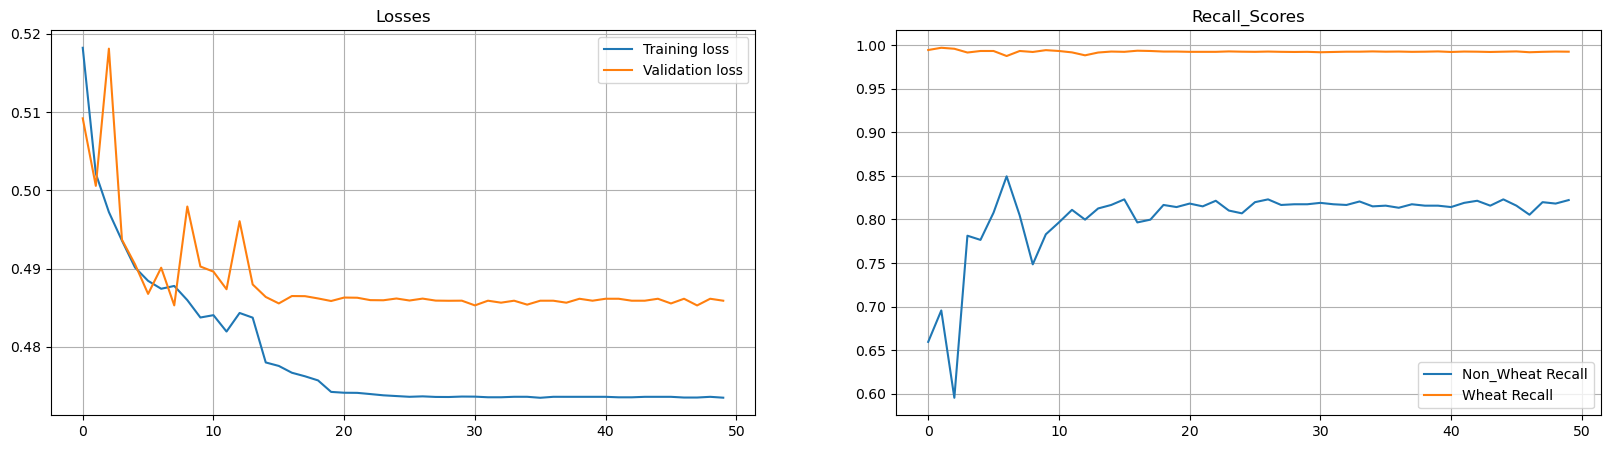

In [ ]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]
hidden_size = 64
hidden_layers = 1
batch_size = batch_size
n_epochs = 50
learning_rate = 1e-2

model_params = {'input_size': input_size,
                'hidden_size' : hidden_size,
                'hidden_layers' : hidden_layers,
                'output_size' : output_size}

model = RNNModel(**model_params)
model.to('cpu')

loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([0.7/0.3, 1]), reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = lr_sc.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.1)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer, lr_scheduler=lr_scheduler)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_size)
opt.plot_losses()

In [ ]:
def new_GT_initial_preprocess():
    
    all_shp_fls = np.array(glob(r'data_files\krishna\**\*.shp', recursive=True))
    pol_shp_files = [files for files in all_shp_fls if 'point' not in files]
    pol_shp_files.remove(pol_shp_files[-2])

    series = pd.Series(gp.read_file(pol_shp_files[0]).columns)
    ndvi_cols = list(series[series.apply(lambda row : True if 'FN' in row else False)])
    
    columns = ['oct_2f', 'nov_1f', 'nov_2f', 'dec_1f', 'dec_2f', 'jan_1f', 'jan_2f', 'feb_1f', 'feb_2f', 'mar_1f', 'label']
    
    tst_pol_wheat = pd.DataFrame(columns = columns)
    tst_pol_mustard = pd.DataFrame(columns = columns)

    for file in pol_shp_files:
        temp = gp.read_file(file)[ndvi_cols[1:11]]
        temp.columns = columns[:-1]
        # temp['district'] = 'SHIVPURI' * temp.shape[0]
        if 'Wheat' in file:
            temp['label'] = [1]*temp.shape[0]
            tst_pol_wheat = pd.concat([tst_pol_wheat, temp],ignore_index=True)
        else:
            temp['label'] = [0]*temp.shape[0]
            tst_pol_mustard = pd.concat([tst_pol_mustard, temp], ignore_index=True)
            
    tst_pol_wheat.iloc[:,:-1] = tst_pol_wheat.iloc[:,:-1].apply(lambda row:round(row*100+100))
    tst_pol_mustard.iloc[:,:-1] = tst_pol_mustard.iloc[:,:-1].apply(lambda row:round(row*100+100))
    tst_pol = pd.concat([tst_pol_wheat, tst_pol_mustard], ignore_index=True)
    
    return pol_shp_files, tst_pol

In [ ]:
shp_files, tst_pol = new_GT_initial_preprocess()

In [ ]:
X_test = scaler.transform(tst_pol.drop('label', axis=1))
y_test = tst_pol['label']

y_test = pd.get_dummies(y_test)

y_test = y_test.astype(int)

test_features = torch.Tensor(X_test)
test_targets = torch.Tensor(y_test.values)

test = TensorDataset(test_features, test_targets)

test_loader = DataLoader(test, batch_size=batch_size, drop_last=True)

In [ ]:
def evaluate(model, test_loader, batch_size, n_features):

    device = 'cpu'

    with torch.no_grad():
        batch_wheat_recall = []
        batch_non_wheat_recall = []
#             y_pred = []
        for x_test, y_test in test_loader:
            x_test = x_test.view([batch_size, -1, n_features]).to(device)
            y_test = y_test.to(device)
            model.eval()
            yhat = model(x_test)
            yhat = np.argmax(yhat, axis=1)
            y_test = np.argmax(y_test, axis=1)
            precision, recall, f1score, support = score(y_test, yhat, labels=[0,1])
#                 print(recall)
            batch_wheat_recall.append(recall[1])
            batch_non_wheat_recall.append(recall[0])
#                 y_pred.append(yhat)

    return np.mean(batch_wheat_recall), np.mean(batch_non_wheat_recall)

best_model = RNNModel(**model_params)
best_model.load_state_dict(torch.load(r'models\RNN_binary_1.1'))

evaluate(best_model, test_loader, batch_size, input_size)

(0.747235576923077, 0.09370993589743591)

In [ ]:
# class EarlyStopping:
#     def __init__(self, tolerance=5, min_delta=0):

#         self.tolerance = tolerance
#         self.min_delta = min_delta
#         self.counter = 0
#         self.early_stop = False

#     def __call__(self, train_loss, validation_loss):
#         if (validation_loss - train_loss) > self.min_delta:
#             self.counter +=1
#             if self.counter >= self.tolerance:  
#                 self.early_stop = True
                


In [ ]:
best_model

RNNModel(
  (rnn): RNN(10, 64, batch_first=True)
  (relu): ReLU()
  (fc): Linear(in_features=64, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)